In [31]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [32]:
PATH = "./"

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [33]:
embedding_dims = 100
batch_size = 32
epochs = 10

In [34]:
train_df = pd.read_csv(PATH+"train.csv")
test_df = pd.read_csv(PATH+"test.csv")

train_df = train_df.loc[:4000]; train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3999,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img
        

In [36]:
train_ds = MNIST(train_df, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [37]:
test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [38]:
anchor_img, positive_img, negative_img, anchor_label = train_ds.__getitem__(0)

In [39]:
anchor_label

1

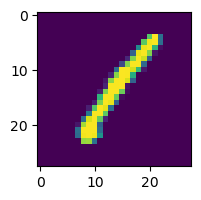

anchor_img


In [40]:
plt.figure(figsize=(2, 2))
plt.imshow(anchor_img.view(28,28), interpolation='nearest')
plt.show() 
print('anchor_img')

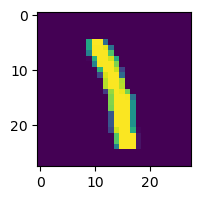

positive_img


In [41]:
plt.figure(figsize=(2, 2))
plt.imshow(positive_img.view(28,28), interpolation='nearest')
plt.show() 
print('positive_img')

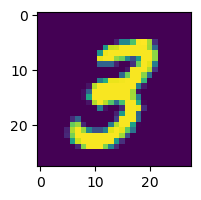

negative_img


In [42]:
plt.figure(figsize=(2, 2))
plt.imshow(negative_img.view(28,28), interpolation='nearest')
plt.show() 
print('negative_img')

In [43]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [44]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
#         x = nn.functional.normalize(x)
        return x

In [45]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [46]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

In [47]:
model.train()
overall_loss_min = 0.010772
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
        
    overall_loss = np.mean(running_loss)
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, overall_loss))
#     if overall_loss <= overall_loss_min:
#             print('loss was improved ({:.6f} --> {:.6f}).  Saving model ...'.format(overall_loss_min, overall_loss))
#             torch.save(model.state_dict(), 'encoder_image.pt')
#             overall_loss_min = overall_loss
#             print("=========================================")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 1/10 - Loss: 0.4104


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 2/10 - Loss: 0.1855


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 3/10 - Loss: 0.1341


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 4/10 - Loss: 0.1308


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 5/10 - Loss: 0.0715


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 6/10 - Loss: 0.0744


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 7/10 - Loss: 0.0625


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 8/10 - Loss: 0.0528


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 9/10 - Loss: 0.0444


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Epoch: 10/10 - Loss: 0.0491


In [21]:
model.load_state_dict(torch.load('../input/model-embedding/encoder_image.pt'))


C:\Users\locua\AppData\Local\Temp\ipykernel_23056\1638313436.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../input/model-embedding/e

FileNotFoundError: [Errno 2] No such file or directory: '../input/model-embedding/encoder_image.pt'

In [48]:
torch.save({"model_state_dict": model.state_dict(),
             "optimzier_state_dict": optimizer.state_dict()
            }, "trained_model.pth")

In [54]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(train_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/126 [00:00<?, ?it/s]

(4001, 100)

C:\Users\locua\AppData\Local\Temp\ipykernel_23056\1268963701.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=0.1, cmap=cm.get_cmap('Spectral', 10))


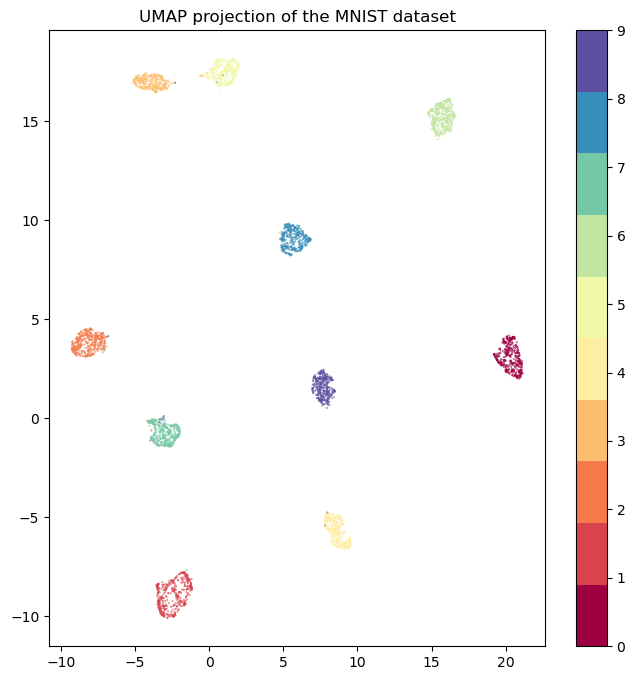

C:\Users\locua\AppData\Local\Temp\ipykernel_23056\1268963701.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(embedding[clustered, 0], embedding[clustered, 1], c=labels_hdb[clustered], s=0.1, cmap=cm.get_cmap('Spectral', 10))


Text(0.5, 1.0, 'UMAP projection of the MNIST dataset')

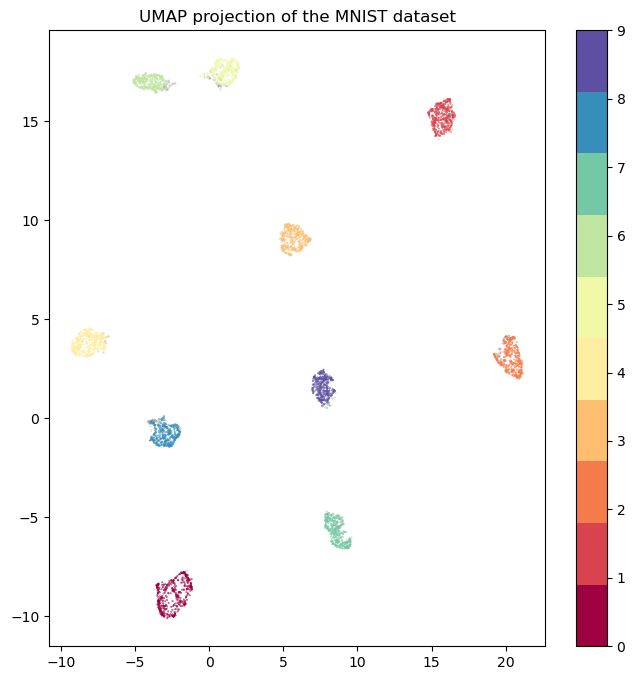

In [57]:
import umap
import matplotlib.cm as cm
import hdbscan

embedding = umap.UMAP(n_neighbors=30, n_components=2, metric='euclidean').fit_transform(train_results)
plt.figure(figsize=(8, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=0.1, cmap=cm.get_cmap('Spectral', 10))
plt.colorbar()
plt.title("UMAP projection of the MNIST dataset")
plt.show()

# HDBSCAN
labels_hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1).fit_predict(train_results)

clustered = (labels_hdb >= 0)
plt.figure(figsize=(8, 8))
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(embedding[clustered, 0], embedding[clustered, 1], c=labels_hdb[clustered], s=0.1, cmap=cm.get_cmap('Spectral', 10))
plt.colorbar()
plt.title("UMAP projection of the MNIST dataset")

C:\Users\locua\AppData\Local\Temp\ipykernel_23056\86009279.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=0.1, cmap=cm.get_cmap('Spectral', 10))


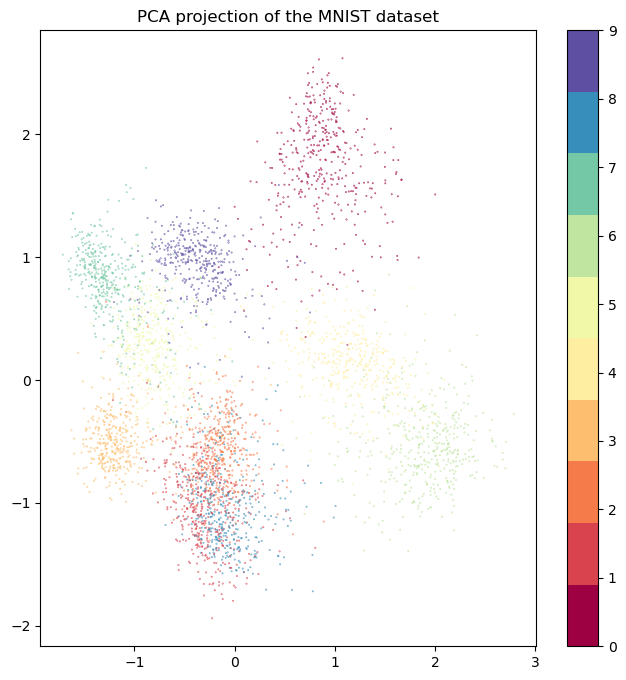

In [58]:
#Compare with PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline


pca = PCA(n_components=2)
pca.fit(train_results)
X_pca = pca.transform(train_results)

plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=0.1, cmap=cm.get_cmap('Spectral', 10))
plt.colorbar()
plt.title("PCA projection of the MNIST dataset")
plt.show()

C:\Users\locua\AppData\Local\Temp\ipykernel_23056\653919929.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=0.1, cmap=cm.get_cmap('Spectral', 10))


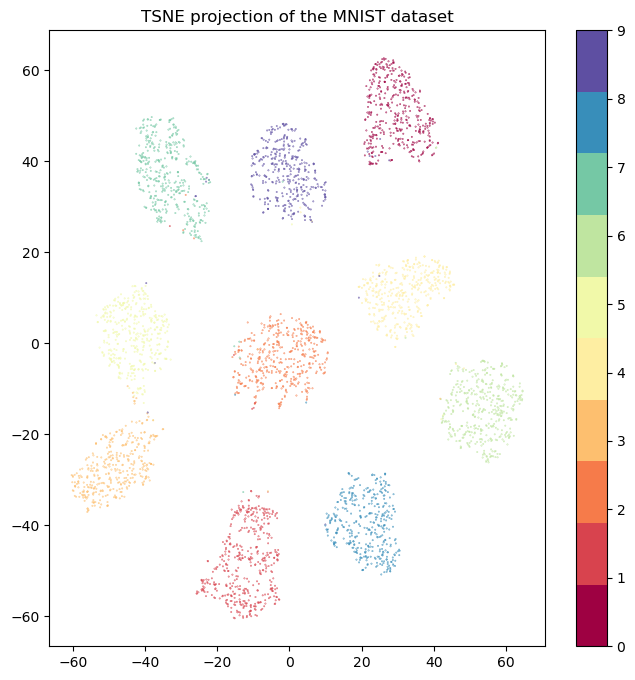

In [60]:
# Test with TSNE
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=2020)
X_tsne = tsne.fit_transform(train_results)

plt.figure(figsize=(8, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, s=0.1, cmap=cm.get_cmap('Spectral', 10))
plt.colorbar()
plt.title("TSNE projection of the MNIST dataset")
plt.show()
